In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random

# Set a fixed seed for reproducibility
torch.manual_seed(66)

In [11]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device being used: {device}")

Device being used: cuda


In [12]:
def prepare_data(batch_size=128, image_size=64):
    
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
    ])
    dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print("Data Preparation Complete")
    print(f"Number of training batches: {len(dataloader)}")
    return dataloader

# Prepare the data
dataloader = prepare_data()


Files already downloaded and verified
Data Preparation Complete
Number of training batches: 391


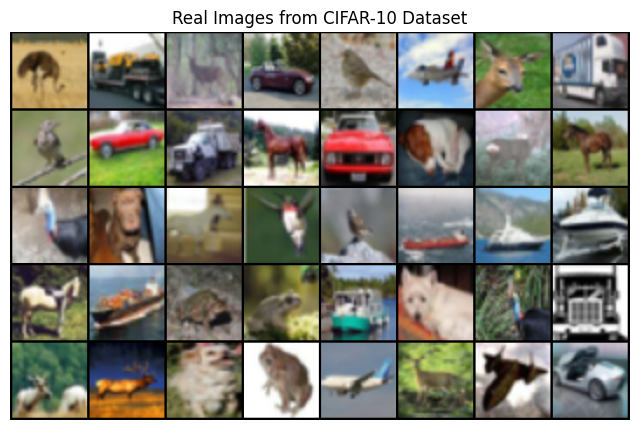

In [13]:
def display_real_images(dataloader, num_images=40):
    
    real_images, _ = next(iter(dataloader))  # Fetch one batch of real images
    real_images = real_images[:num_images] * 0.5 + 0.5  # Undo normalization to [0, 1]

    # Plot real images in a grid
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Real Images from CIFAR-10 Dataset")
    plt.imshow(np.transpose(torchvision.utils.make_grid(real_images, padding=2, normalize=False), (1, 2, 0)))
    plt.show()

# Example Usage
display_real_images(dataloader)


In [14]:
class WGANGenerator(nn.Module):
    def __init__(self, nz, ngf):
        super(WGANGenerator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Initialize Generator
nz, ngf = 100, 64  # Latent vector size and generator feature size
netG = WGANGenerator(nz, ngf).to(device)
print("WGAN Generator Model Summary:")
print(netG)


WGAN Generator Model Summary:
WGANGenerator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), b

In [15]:
class WGANDiscriminator(nn.Module):
    def __init__(self, ndf):
        super(WGANDiscriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        return self.main(input).view(-1)

# Initialize Discriminator
ndf = 64  # Discriminator feature size
netD = WGANDiscriminator(ndf).to(device)
print("WGAN Discriminator Model Summary:")
print(netD)


WGAN Discriminator Model Summary:
WGANDiscriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


In [16]:
def weight_clipping(net, clip_value):
    
    for p in net.parameters():
        p.data.clamp_(-clip_value, clip_value)


In [17]:
from torchmetrics.image.fid import FrechetInceptionDistance

def train_wgan_with_fid(netG, netD, dataloader, optimizerG, optimizerD, nz, device, num_epochs=25, clip_value=0.01, n_critic=5):
    
    G_losses, D_losses, FID_scores = [], [], []

    # Initialize FID metric
    fid = FrechetInceptionDistance(feature=2048).to(device)

    print("Starting Training...\n")
    for epoch in range(num_epochs):
        for i, (data, _) in enumerate(dataloader):
            ### Train Critic ###
            netD.zero_grad()
            real_images = data.to(device)
            b_size = real_images.size(0)
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_images = netG(noise)

            # Compute loss for real and fake images
            D_loss_real = -torch.mean(netD(real_images))
            D_loss_fake = torch.mean(netD(fake_images.detach()))
            D_loss = D_loss_real + D_loss_fake
            D_loss.backward()
            optimizerD.step()

            # Weight clipping for critic
            weight_clipping(netD, clip_value)

            # Train Generator every n_critic steps
            if i % n_critic == 0:
                netG.zero_grad()
                noise = torch.randn(b_size, nz, 1, 1, device=device)
                fake_images = netG(noise)
                G_loss = -torch.mean(netD(fake_images))
                G_loss.backward()
                optimizerG.step()

                # Record losses
                G_losses.append(G_loss.item())
                D_losses.append(D_loss.item())

        ### FID Calculation ###
        fid.reset()  # Clear FID state

        # Add real images to FID metric
        for real_batch, _ in dataloader:
            real_batch = (real_batch * 0.5 + 0.5) * 255  # Denormalize to [0, 255]
            real_batch = real_batch.to(torch.uint8).to(device)  # Convert to uint8
            fid.update(real_batch, real=True)

        # Add fake images to FID metric
        with torch.no_grad():
            for _ in range(len(dataloader)):
                fake_batch = netG(torch.randn(b_size, nz, 1, 1, device=device))
                fake_batch = (fake_batch * 0.5 + 0.5) * 255  # Denormalize to [0, 255]
                fake_batch = fake_batch.to(torch.uint8).to(device)  # Convert to uint8
                fid.update(fake_batch, real=False)

        # Compute FID score
        fid_score = fid.compute().item()
        FID_scores.append(fid_score)

        print(f"End of Epoch [{epoch+1}/{num_epochs}] - Loss_D: {D_loss.item():.4f}, "
              f"Loss_G: {G_loss.item():.4f}, FID: {fid_score:.4f}\n")

    print("Training Complete!\n")
    return G_losses, D_losses, FID_scores


In [18]:
# Define noise size and learning rate
nz = 100  # Size of the noise vector
lr = 0.00005  # Learning rate for WGAN

# Initialize models
netG = WGANGenerator(nz, 64).to(device)
netD = WGANDiscriminator(64).to(device)

# Optimizers for Generator and Discriminator
optimizerG = optim.RMSprop(netG.parameters(), lr=lr)
optimizerD = optim.RMSprop(netD.parameters(), lr=lr)

# Train the WGAN with FID calculation
G_losses, D_losses, FID_scores = train_wgan_with_fid(
    netG, netD, dataloader, optimizerG, optimizerD, nz, device, num_epochs=100, clip_value=0.01, n_critic=5
)


Starting Training...

End of Epoch [1/100] - Loss_D: -1.3975, Loss_G: 0.6882, FID: 333.5019

End of Epoch [2/100] - Loss_D: -1.4794, Loss_G: 0.7297, FID: 383.3066

End of Epoch [3/100] - Loss_D: -1.5204, Loss_G: 0.7497, FID: 350.0617

End of Epoch [4/100] - Loss_D: -1.4915, Loss_G: 0.7313, FID: 326.8245

End of Epoch [5/100] - Loss_D: -1.5307, Loss_G: 0.7507, FID: 328.5692

End of Epoch [6/100] - Loss_D: -1.5131, Loss_G: 0.7447, FID: 335.4963

End of Epoch [7/100] - Loss_D: -1.5405, Loss_G: 0.7575, FID: 337.8440

End of Epoch [8/100] - Loss_D: -1.5195, Loss_G: 0.7468, FID: 323.7842

End of Epoch [9/100] - Loss_D: -1.5366, Loss_G: 0.7545, FID: 325.2850

End of Epoch [10/100] - Loss_D: -1.4919, Loss_G: 0.7434, FID: 324.2675

End of Epoch [11/100] - Loss_D: -1.5231, Loss_G: 0.7507, FID: 323.4865

End of Epoch [12/100] - Loss_D: -1.5077, Loss_G: 0.7439, FID: 322.1425

End of Epoch [13/100] - Loss_D: -1.5442, Loss_G: 0.7590, FID: 307.0640

End of Epoch [14/100] - Loss_D: -1.5180, Loss_G: 0.

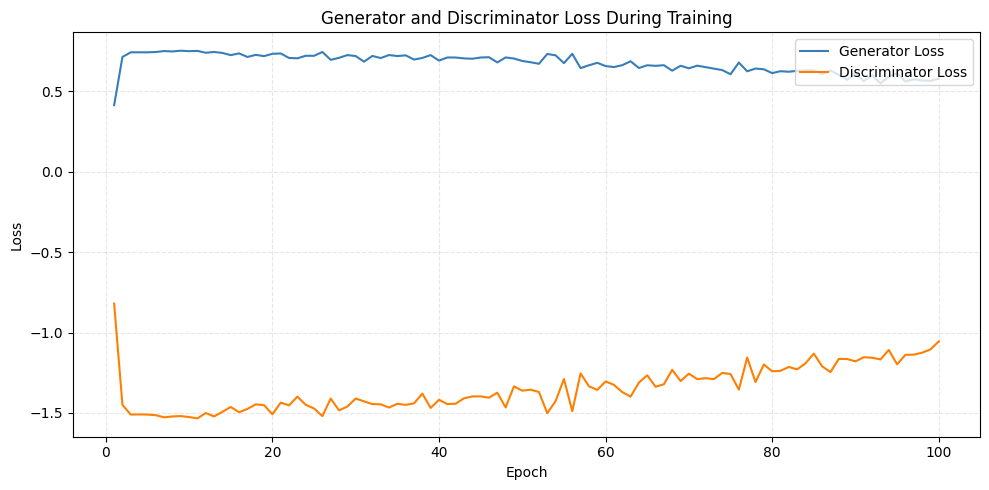

In [19]:
def plot_epoch_loss_graphs(G_losses, D_losses, num_epochs):
    
    # Split losses into epochs
    iterations_per_epoch = len(G_losses) // num_epochs
    G_losses_epoch = [np.mean(G_losses[i * iterations_per_epoch:(i + 1) * iterations_per_epoch]) for i in range(num_epochs)]
    D_losses_epoch = [np.mean(D_losses[i * iterations_per_epoch:(i + 1) * iterations_per_epoch]) for i in range(num_epochs)]

    # Plot epoch-aggregated losses with specified colors
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), G_losses_epoch, label="Generator Loss", color="#377eb8")  # Blue
    plt.plot(range(1, num_epochs + 1), D_losses_epoch, label="Discriminator Loss", color="#ff7f00")  # Orange
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Generator and Discriminator Loss During Training")
    plt.legend(loc="upper right")
    plt.grid(alpha=0.3, linestyle="--")
    plt.tight_layout()
    plt.show()

# Example usage
plot_epoch_loss_graphs(G_losses, D_losses, num_epochs=100)


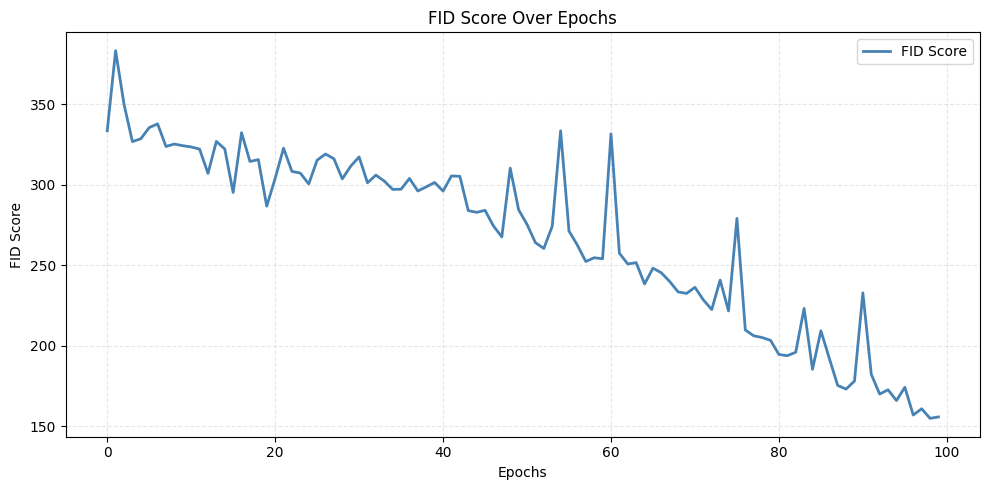

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(FID_scores, label="FID Score", color='steelblue', linewidth=2)  # Use "steelblue" for the line color
plt.xlabel("Epochs")
plt.ylabel("FID Score")
plt.title("FID Score Over Epochs")
plt.legend(loc="upper right")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()


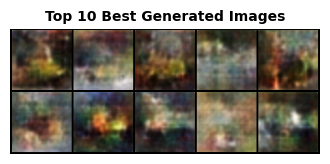

In [27]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch

def display_top_10_fake_images(generator, discriminator, nz, device, batch_size=1000, num_images=10):
    
    generator.eval()  # Set generator to evaluation mode
    discriminator.eval()  # Set discriminator to evaluation mode

    # Generate a large batch of fake images for evaluation
    noise = torch.randn(batch_size, nz, 1, 1, device=device)
    with torch.no_grad():
        fake_images = generator(noise).detach().cpu()  # Generate fake images on CPU for visualization
        fake_images_gpu = generator(noise).detach()  # Generate fake images on GPU for scoring

    # Get discriminator scores for fake images
    with torch.no_grad():
        scores = discriminator(fake_images_gpu).view(-1).detach().cpu().numpy()  # Discriminator scores

    # Sort fake images by discriminator scores (highest scores first)
    sorted_indices = scores.argsort()[::-1][:num_images]  # Get indices of top `num_images` scores
    best_fake_images = torch.stack([fake_images[i] for i in sorted_indices])  # Select top `num_images` images

    # Display the top 10 fake images in a grid (2 rows, 5 columns)
    grid = vutils.make_grid(best_fake_images, nrow=5, padding=2, normalize=True)  # Adjust grid layout
    plt.figure(figsize=(4, 4))  # Adjust figure size to match DCGAN output
    plt.axis("off")
    plt.title(f"Top {num_images} Best Generated Images", fontsize=10, fontweight="bold")
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))  # Transpose dimensions for visualization
    plt.show()

# Example usage
display_top_10_fake_images(netG, netD, nz=100, device=device, batch_size=1000, num_images=10)


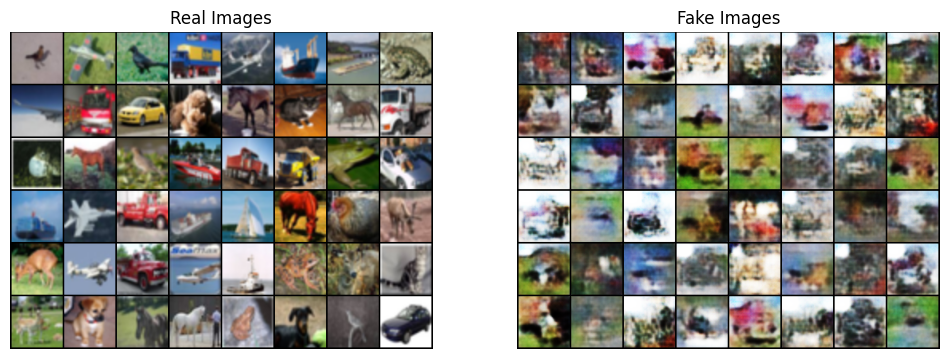

In [26]:
def display_real_and_fake_images_wgan(dataloader, netG, nz, device, num_images=48):
    
    # Fetch a batch of real images
    real_images, _ = next(iter(dataloader))  # Get a batch of real images
    real_images = real_images[:num_images] * 0.5 + 0.5  # Undo normalization to [0, 1]

    # Generate a batch of fake images
    fixed_noise = torch.randn(num_images, nz, 1, 1, device=device)  # Fixed noise for consistency
    with torch.no_grad():
        fake_images = netG(fixed_noise).detach().cpu() * 0.5 + 0.5  # Undo normalization to [0, 1]

    # Create the figure and display both sets of images
    plt.figure(figsize=(12, 6))

    # Display real images on the left
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(real_images, padding=2, normalize=False), (1, 2, 0)))

    # Display fake images on the right
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(fake_images, padding=2, normalize=False), (1, 2, 0)))

    plt.show()

# Example usage
display_real_and_fake_images_wgan(dataloader, netG, nz=100, device=device, num_images=48)
